# Parsing of Internal and External Causes of Errors (PIECE) Model 
---

## Generative Model

\begin{align}
p(C = 1) &= 0.5 \\
p(C = 2) &= 0.5 \\
p(x_h | C = 1) &= N(0, \sigma_m^2) \\
p(x_h | C = 2) &= N(0, \sigma_m^2) \\
p(r | C = 2) &= N(0, \sigma_{\text{pert}}^2) \\
p(x_v | x_h, r) &= N(x_h + r, \sigma_v^2) \\
p(x_p | x_h) &= N(x_h, \sigma_p^2) \\
p(x_u | x_h) &= N(x_h, \sigma_u^2) 
\end{align}

- $C$ stands for Cause: $C=1$ means there is no rotation (perturbation), while $C=2$ indicates a rotation. The observer has a flat prior on $C$.
- $x_h$ refers to the hand position, or trajectory. This model assumes the probability distribution is the same whether the reach is perturbed or not; also, the model assumes the observer has knowledge regarding the distribution of their internally-generated errors (IGE), or, motor noise.
- $r$ is the perturbation. The observer has a stronger prior on small perturbations versus larger ones. 

There are 3 cues about the location of reach endpoint:
- $\hat{x}_v$, visual feedback
- $\hat{x}_p$, proprioceptively sensed hand location
- $\hat{x}_u$, efference copy prediction-based cue

## Inference

First inference is on the causal node $C$. 

\begin{align}
p(C|x_v, x_p, x_u) \propto p(x_v, x_p, x_u|C)p(C)
\end{align}

---
## Simulations

### Technical Issues and Next Steps:
- Takes way too long to run - do I need to vectorize code? If so, what's a good model of that--Hudson model selection tutorial? 
- Other strategies to speed up computations:
    - To compute $p(C|\vec{x})$, seems like you should be able to compute very quickly using closed-form solutions for integrals of Gaussians (see Kording et al 2007, equations 1-6). Perhaps take product of Gaussians and then calculate integral.
    - For stimulus estimates, looks like you can compute estimates directly without computing full posterior (see Kording et al 2007, equations 7-10)
- Incorporate un-normalized values (i.e., ones that are not a proportion of normalized motor noise, $\sigma_f$.

### Conceptual Issues/Questions:
- What does PIECE predict regarding adaptation to consistent perturbation (e.g., $30^{\circ}$ rotation)?
- Shift in proprioception or perceived hand position? Need to infer hand position. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import integrate
from scipy.stats import norm
from scipy.special import logsumexp
from statsmodels.nonparametric.smoothers_lowess import lowess

%config InlineBackend.figure_format = "retina"

In [2]:
def calc_prob_gauss(x, mu, sigma, bin_width=0.1):
    prob = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(x - mu)**2 / (2 * sigma**2))
    prob = prob * bin_width
    return prob

In [3]:
# Simulated parameters
pert_size = np.array([-10, -5, -3.3, -2.2, -1.5, 0, -1, 1, 1.5, 2.2, 3.3, 5, 10])
n_per_pert = 30
num_trials = len(pert_size) * n_per_pert * 2 + 1  # must add one to get correct number of adaptation measures using triplet method
perts = np.repeat(pert_size, int(num_trials / 2 / len(pert_size)))
perts = np.random.permutation(perts)
delta_x = np.zeros(num_trials)
delta_x[1::2] = perts

# Model parameters. Following values generate realistic simulations:
# sigma_u = 0.01; sigma_p = 1.5; sigma_f = 1; sigma_pert = 1.2; sigma_v = 0.33 + 0.2 * np.abs(x_f[i] + delta_x[i])
sigma_u = 0.01
sigma_p = 1.5
sigma_f = 1  # Normalized motor variabilty, thus equals 1
# sigma_pert = 3.5  # setting it to this level causes reverse adaptation to ige
sigma_pert = 1.2  
b = 0  # Subject's motor bias

x_grid = np.arange(-10, 10, 0.1)  # Possible endpoint locations

# Function for computing log-probabilities
f = lambda x, mu, sigma: -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * (x - mu)**2 / sigma**2

In [4]:
# Simulate data
random = 0
eps = np.random.normal(loc=0, scale=sigma_f, size=num_trials)  # motor noise
if random == 1:
    xhat_u = np.random.normal(loc=x_f, scale=sigma_u, size=num_trials)
    xhat_p = np.random.normal(loc=x_f, scale=sigma_p, size=num_trials)
    xhat_v = np.random.normal(loc=x_f + delta_x, scale=sigma_v, size=num_trials)

# Ideal observer 
likelihood_nopert = []
likelihood_pert = []
likelihood_mat = np.zeros((len(x_grid), len(x_grid)))
decision_pert = []
post_pert = []
logprobs_nopert = np.zeros(len(x_grid))
logprobs_pert = np.zeros((len(x_grid), len(x_grid)))
ll_delta_x = np.zeros((len(x_grid), len(x_grid)))
log_post_delta_x = np.zeros((num_trials, len(x_grid)))
delta_x_pme = np.zeros(num_trials)
delta_x_hat = np.zeros(num_trials)
x_f = np.zeros(num_trials)
x_f_kalm = np.zeros(num_trials)

# first, loop through trials
for i in range(num_trials - 1):  
    if i==0:
        x_f[i] = eps[i]
    xhat_u = x_f[i]
    xhat_p = x_f[i]
    xhat_v = x_f[i] + delta_x[i]
    sigma_v = 0.3 + 0.2 * np.abs(x_f[i] + delta_x[i])  # after Zhang et al
    total_nopert = 0
    total_pert = 0
    
    # Kalman filtering
    sigma_mapping = 1.2
    J_v = 1 / sigma_v**2
    J_mapping = 1 / sigma_mapping**2
    K = J_v / (J_v + J_mapping)
    state_est = K * (delta_x[i] - 0)
    
    for j in range(len(x_grid)):
        # Need to convert to prob mass bc we are summing up probs
        logprobs_nopert[j] = f(xhat_u, x_grid[j], sigma_u) + f(xhat_v, x_grid[j], sigma_v) \
        + f(xhat_p, x_grid[j], sigma_p) + f(x_grid[j], b, sigma_f)
        for k in range(len(x_grid)):
            logprobs_pert[j, k] = f(xhat_u, x_grid[j], sigma_u) + f(xhat_v, x_grid[j] + x_grid[k], sigma_v) \
            + f(xhat_p, x_grid[j], sigma_p) + f(x_grid[k], 0, sigma_pert) + f(x_grid[j], b, sigma_f)  
            ll_delta_x[j, k] = f(xhat_v, x_grid[k] + x_grid[j], sigma_v) + f(x_grid[k], b, sigma_f)
        log_post_delta_x[i, j] = logsumexp(f(x_grid[j], 0, sigma_pert) + ll_delta_x[j, :].flatten(), b=0.01)
    
    total_nopert = logsumexp(logprobs_nopert, b=0.1)
    total_pert = logsumexp(logprobs_pert.flatten(), b=0.01)
    likelihood_nopert.append(total_nopert)
    likelihood_pert.append(total_pert)
    decision_pert.append(np.array(likelihood_nopert[-1]) < np.array(likelihood_pert[-1]))
    post_pert.append(np.exp(total_pert) / (np.exp(total_pert) + np.exp(total_nopert)))  # posterior on Cause
    
    delta_x_pme[i] = x_grid[np.argmax(np.exp(log_post_delta_x[i, :]))]
    delta_x_hat[i] = post_pert[i] * delta_x_pme[i]

    x_f[i + 1] = delta_x_hat[i]*-1 + eps[i + 1]
    x_f_kalm[i + 1] = state_est * -1 + eps[i + 1]

decision_pert.append(False)
post_pert.append(0)

In [5]:
adaptation = np.zeros(num_trials)
adaptation_kalm = np.zeros(num_trials)
adaptation[1:-1:2] = x_f[2::2] - x_f[0:-1:2]
adaptation_kalm[1:-1:2] = x_f_kalm[2::2] - x_f_kalm[0:-1:2]
df = pd.DataFrame({"x_f":x_f, "delta_x":delta_x, "post_pert":post_pert, "delta_x_pme":np.round(delta_x_pme, 2), 
                   "delta_x_hat":np.round(delta_x_hat, 2), "adaptation":adaptation, "adaptation_kalm": adaptation_kalm,
                   "decision_pert":decision_pert})
df.head(20)

,x_f,delta_x,post_pert,delta_x_pme,delta_x_hat,adaptation,adaptation_kalm,decision_pert
0,1.384261,0.0,0.302349,0.7,0.21,0.000000,0.000000,False
1,-0.110840,-1.0,0.658511,-0.6,-0.40,-0.314086,1.515866,True
2,1.070175,0.0,0.282803,0.6,0.17,0.000000,0.000000,False
3,1.360382,3.3,0.797531,1.7,1.36,-2.336415,-3.032788,True
4,-1.266240,0.0,0.295441,-0.7,-0.21,0.000000,0.000000,False
5,-0.713311,-3.3,0.886662,-1.6,-1.42,2.381291,3.002562,True
6,1.115051,0.0,0.285552,0.6,0.17,0.000000,0.000000,False
7,-0.408436,3.3,0.982809,1.3,1.28,-3.127893,-4.369663,True
8,-2.012842,0.0,0.335686,-1.0,-0.34,0.000000,0.000000,False
9,0.341145,-5.0,0.973718,-1.7,-1.66,2.863097,4.513644,True


In [6]:
df_adapt = df.iloc[1::2]

In [7]:
# df.groupby("delta_x")["decision_pert"].mean()
df_adapt.groupby("delta_x")[["post_pert", "adaptation", "adaptation_kalm"]].mean().reset_index()

,delta_x,post_pert,adaptation,adaptation_kalm
0,-10.0,0.871276,1.575373,2.113505
1,-5.0,0.939681,2.094952,3.157396
2,-3.3,0.923566,1.238856,2.099837
3,-2.2,0.889470,0.962561,1.583454
4,-1.5,0.851679,0.470290,1.214272
5,-1.0,0.694974,0.428880,0.798529
6,0.0,0.269655,-0.064069,-0.278551
7,1.0,0.725083,0.111316,-0.349821
8,1.5,0.819795,-1.058537,-2.051166
9,2.2,0.874801,-1.330886,-1.827655


In [8]:
df.groupby("delta_x")["decision_pert"].apply(lambda x: float(x.sum()) / x.count()).reset_index()

,delta_x,decision_pert
0,-10.0,1.0
1,-5.0,1.0
2,-3.3,1.0
3,-2.2,1.0
4,-1.5,1.0
5,-1.0,0.8
6,0.0,0.0
7,1.0,0.9
8,1.5,1.0
9,2.2,1.0


/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


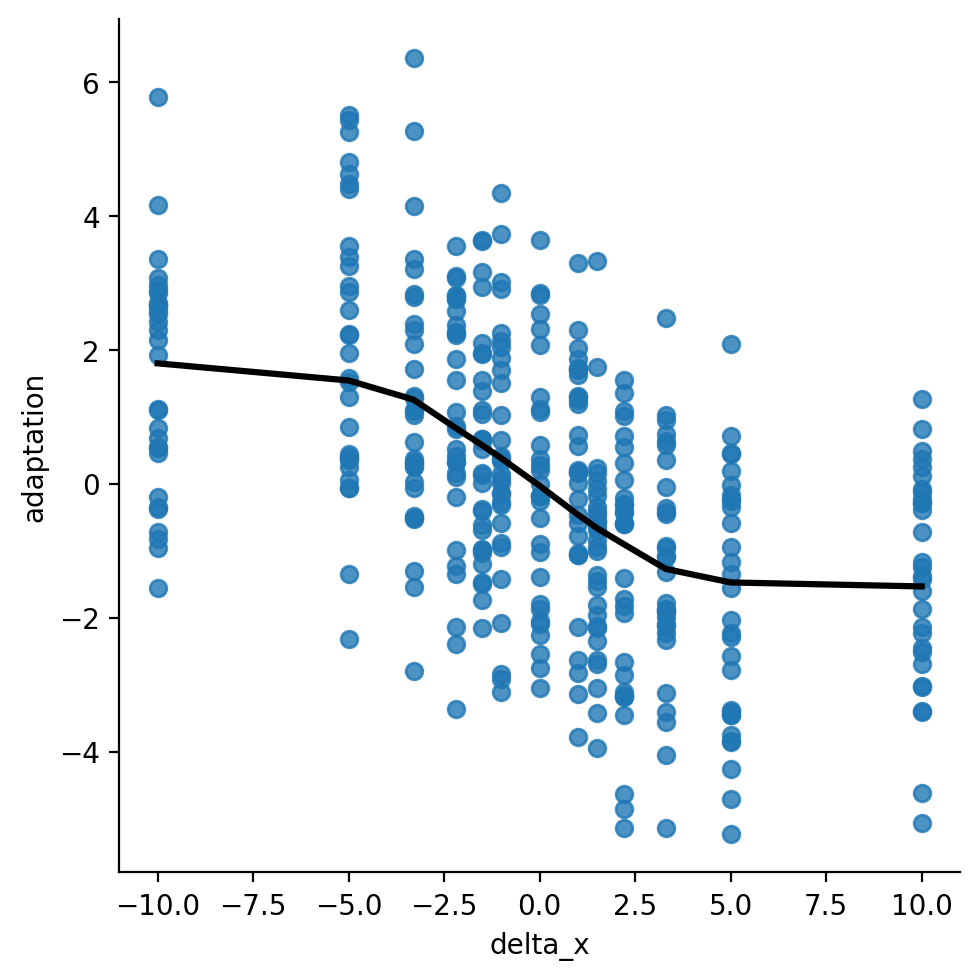

In [9]:
sns.lmplot(data=df_adapt, x="delta_x", y="adaptation", lowess=True, line_kws={"color":"k"})
plt.show()

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


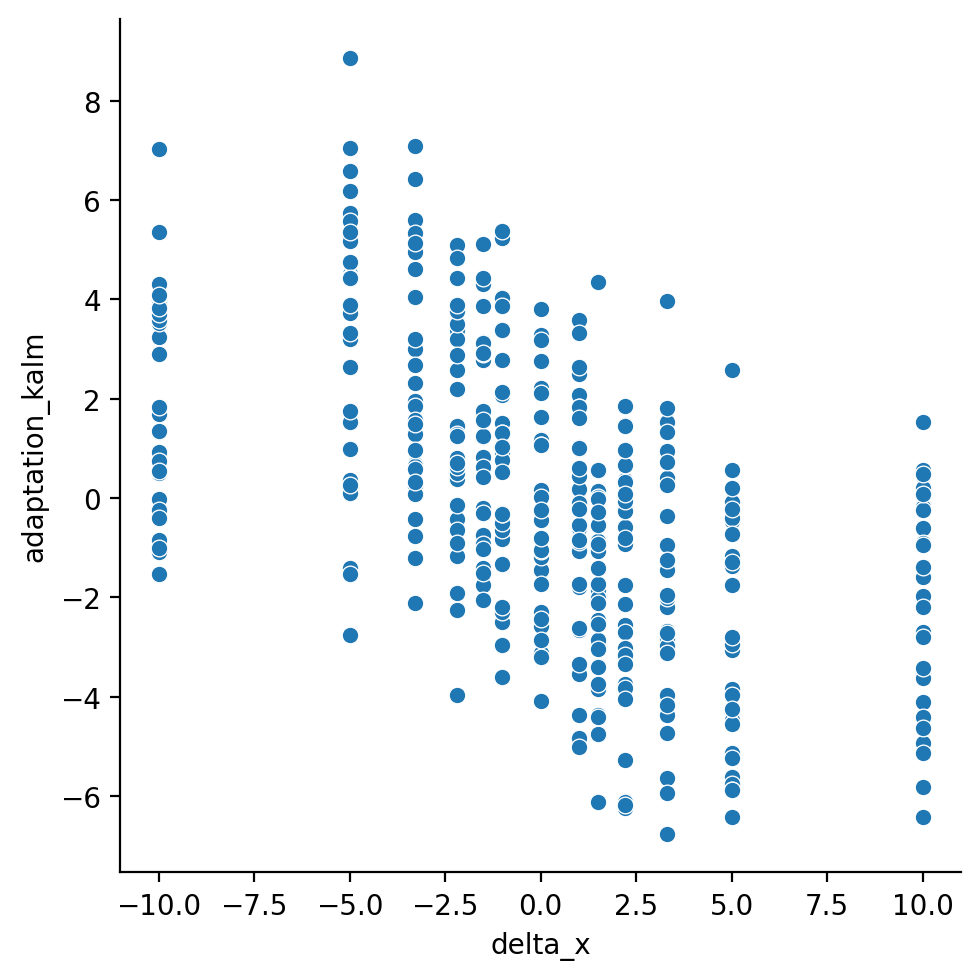

In [10]:
sns.relplot(data=df_adapt, x="delta_x", y="adaptation_kalm")
plt.show()

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


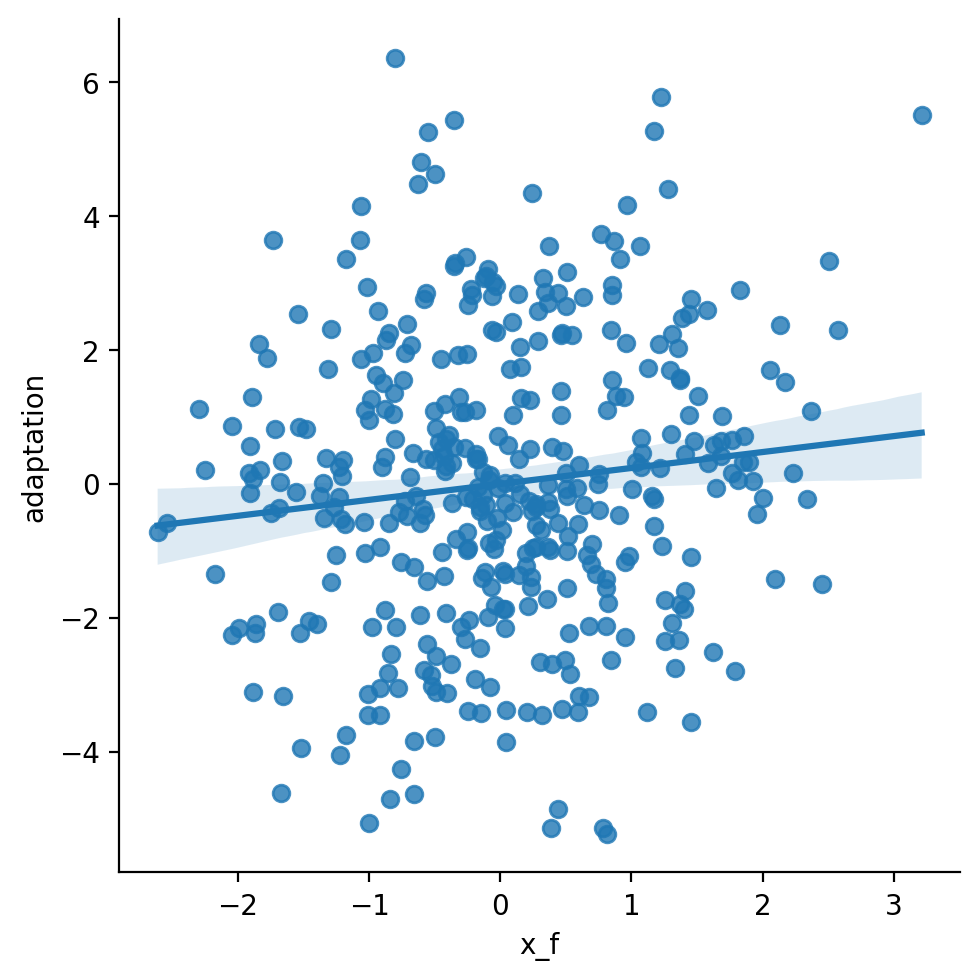

In [11]:
sns.lmplot(data=df_adapt, x="x_f", y="adaptation")
plt.show()

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


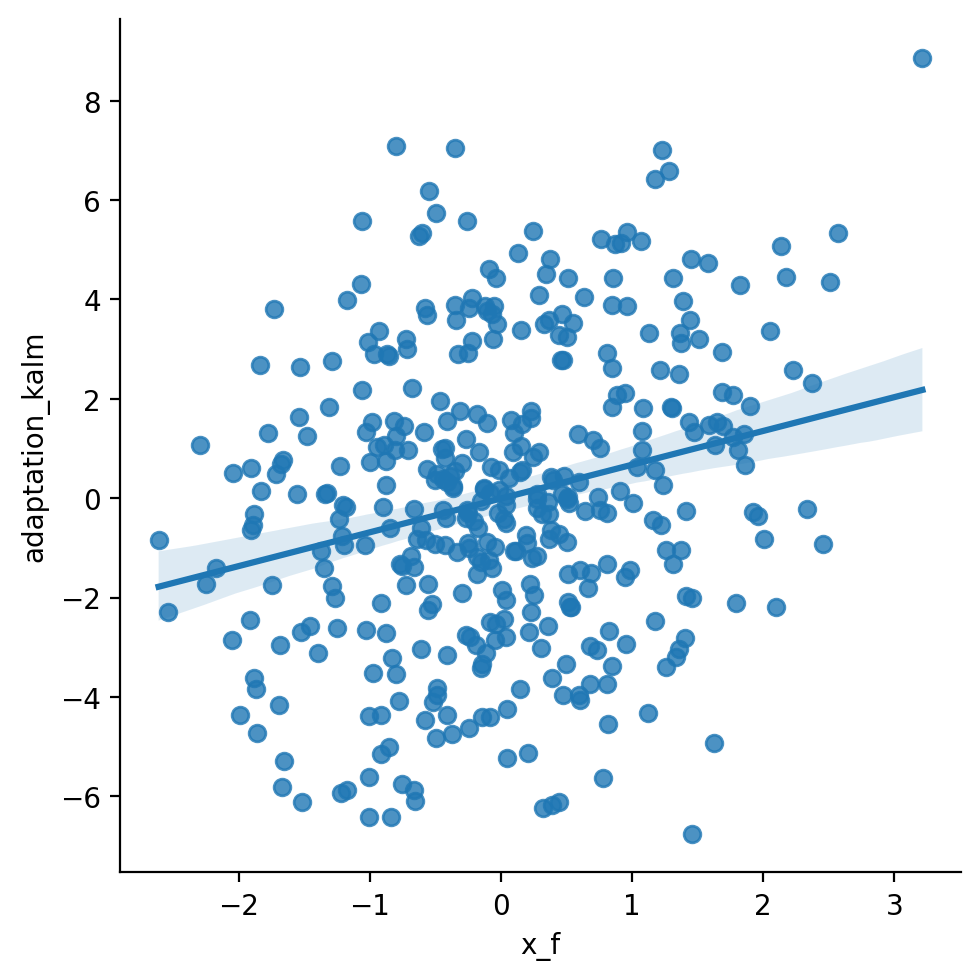

In [12]:
sns.lmplot(data=df_adapt, x="x_f", y="adaptation_kalm")

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


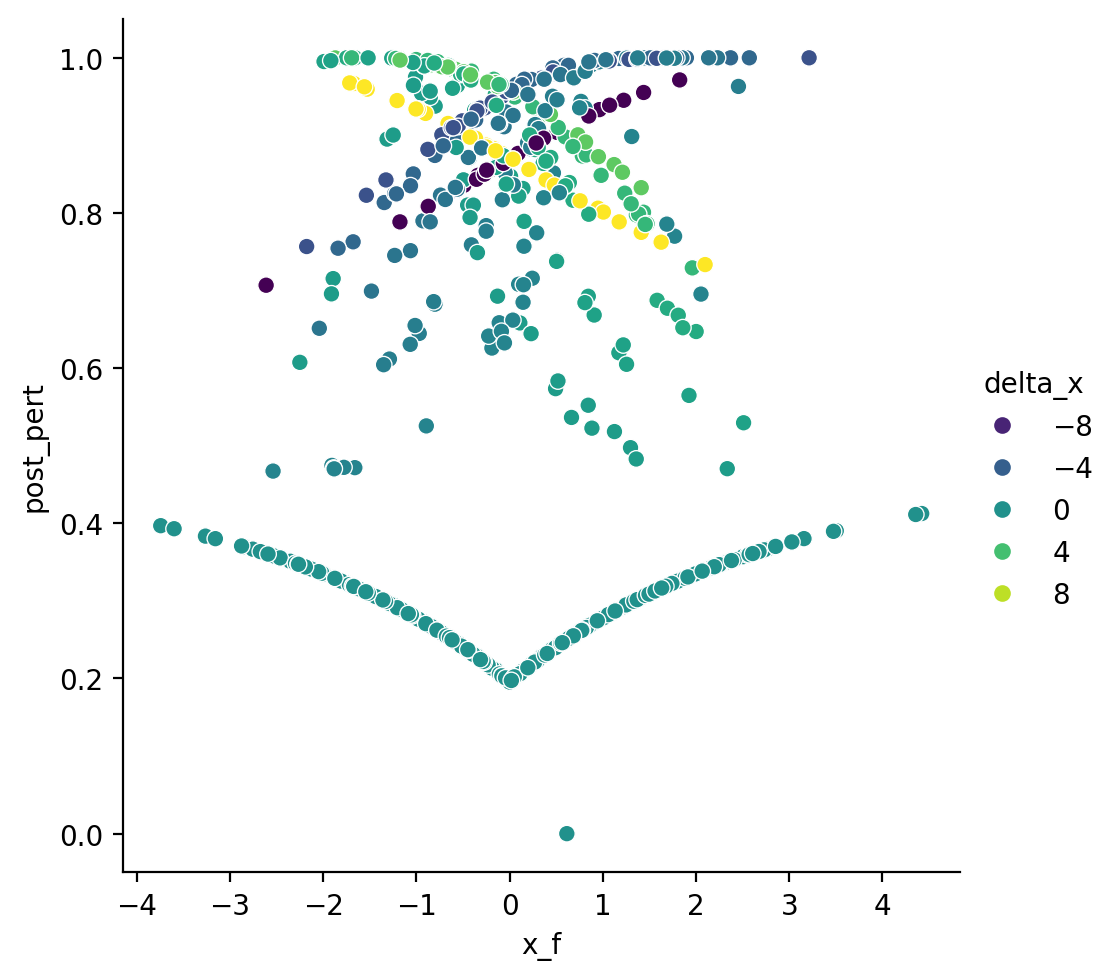

In [13]:
sns.relplot(data=df, x="x_f", y="post_pert", hue="delta_x", palette="viridis")

In [14]:
# Kalman filtering
sigma_mapping = 1.2
J_v = 1 / sigma_v**2
J_mapping = 1 / sigma_mapping**2
K = J_v / (J_v + J_mapping)
state_est = K * (delta_x - 0)
adapt2 = state_est * -1
df["adapt2"] = adapt2

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


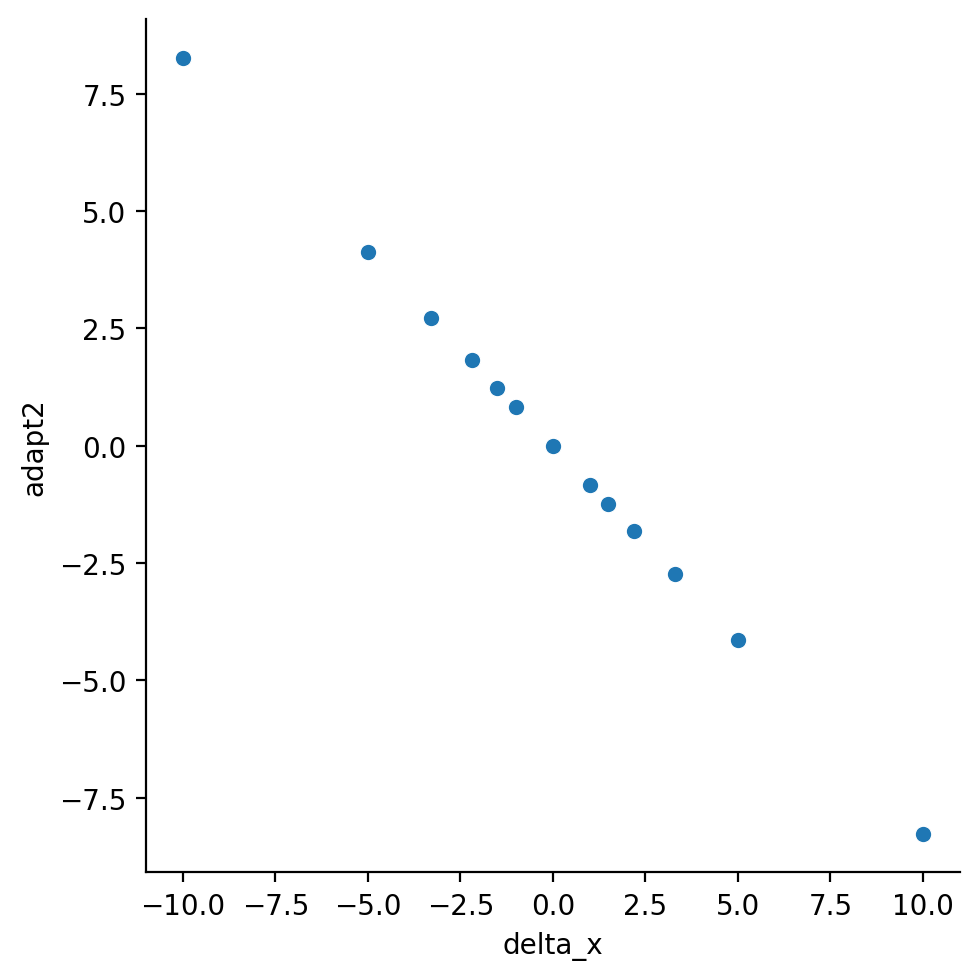

In [15]:
sns.relplot(kind="scatter", data=df, x="delta_x", y="adapt2")

/Users/hyosubkim/opt/anaconda3/envs/ige-ege/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


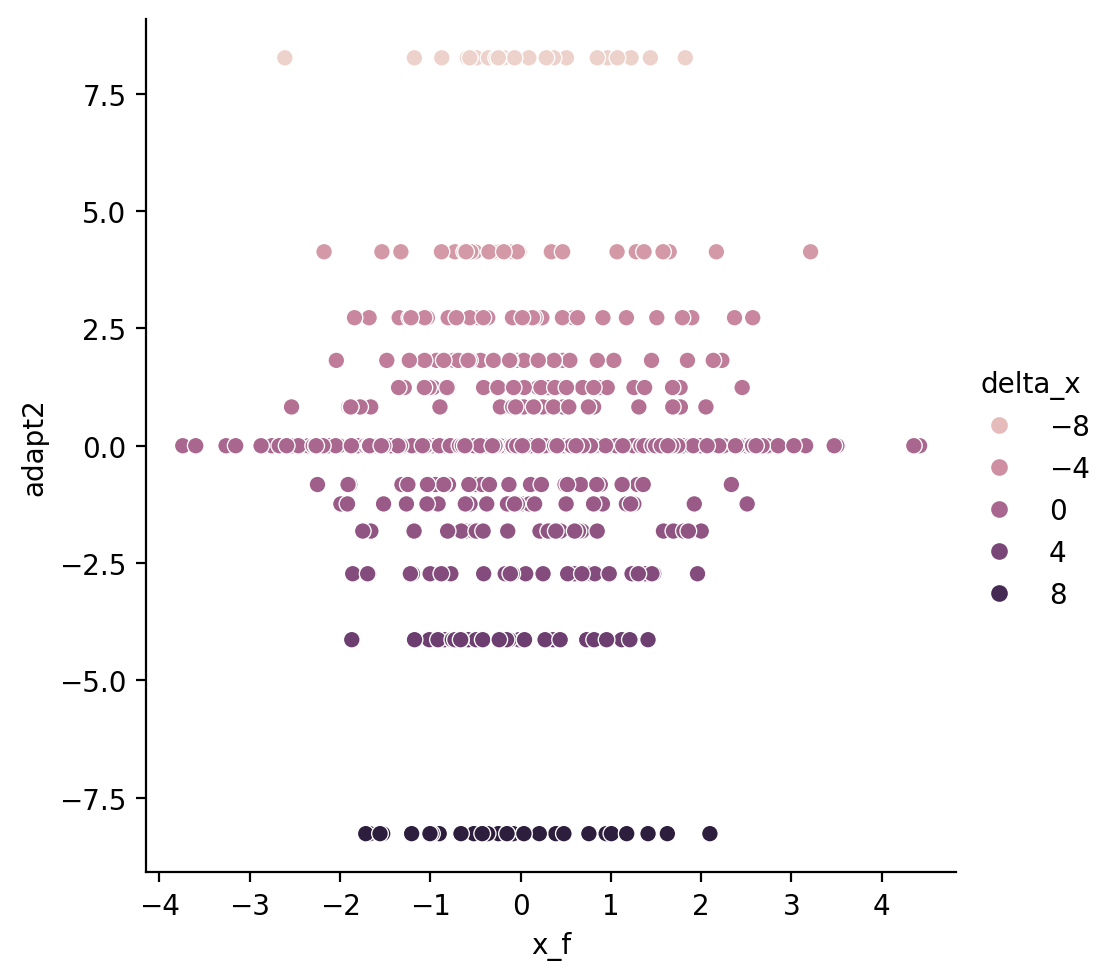

In [16]:
sns.relplot(kind="scatter", data=df, x="x_f", y="adapt2", hue="delta_x")

(array([  4.,  31.,  80., 157., 202., 157.,  97.,  44.,   7.,   2.]),
 array([-3.74173165, -2.92546146, -2.10919127, -1.29292108, -0.47665088,
         0.33961931,  1.1558895 ,  1.97215969,  2.78842988,  3.60470008,
         4.42097027]),
 <BarContainer object of 10 artists>)

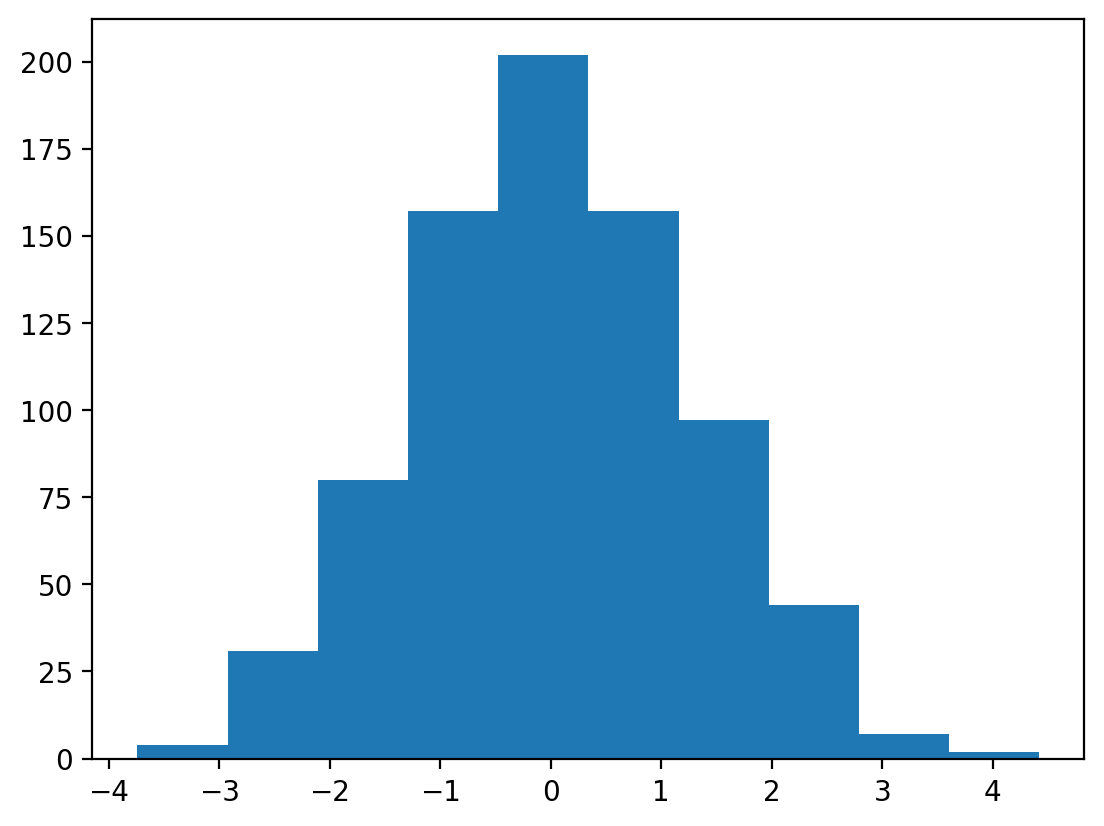

In [17]:
plt.hist(x_f)